In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.multitest as multi

from CosinorPy import file_parser, cosinor, cosinor1
from CosinorPy.helpers import df_add_row
from RhythmCount import data_processing as dproc
from RhythmCount import plot

In [35]:
accidents_moon = pd.read_csv("../nesrece_lunine_mene_2010_2023.csv")
# display(accidents_moon)

C:\Users\Hana\AppData\Local\Temp\ipykernel_44836\4041037844.py:1: DtypeWarning: Columns (31,32,33,34,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  accidents_moon = pd.read_csv("../nesrece_lunine_mene_2010_2023.csv")


In [36]:
# Nastavljanje pravilnega časovnega pasu
accidents_moon['NastanekDatumCas'] = pd.to_datetime(accidents_moon['NastanekDatumCas'], format='ISO8601', utc=True, errors='coerce')
accidents_moon['NastanekDatumCas'] = accidents_moon['NastanekDatumCas'].dt.tz_convert('Europe/Ljubljana')
print(f"NastanekDatumCas column dtype: {accidents_moon['NastanekDatumCas'].dtype}")
#display(accidents_moon)

NastanekDatumCas column dtype: datetime64[ns, Europe/Ljubljana]


## CosinorPy - dnevi brez luninih men

Preverila bom, če se ritmičnost nesreč, ki so se zgodile izven tistih dni, ko se menjajo lunine mene, razlikuje od ritmičnosti nesreč, ki so se zgodile v času menjanja luninih men.

In [37]:
# Maska za luno
accidents_moon['moon_phase'] = accidents_moon['moon_phase'].fillna('None')
moon_mask = (accidents_moon['moon_phase'] == 'None')

accidents_none = accidents_moon[moon_mask]
# display(accidents_none)

# Za vsak vnos pridobi znotraj, katere ure se je zgodil
hours = accidents_none['NastanekDatumCas'].dt.hour

accidents_per_hour = hours.value_counts()

# Uredi podatke po vrstnem redu ur (naraščajoče)
accidents_per_hour = accidents_per_hour.sort_index()
# print(accidents_per_hour)

# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo CosinorPy
df_plot = pd.DataFrame({
    "test": "HourlyAccidentsNone",  # konstantna oznaka vseh vrstic
    "x": accidents_per_hour.index,  # Ura (od 0 do 23)
    "y": accidents_per_hour.values  # Število nesreč za tisto uro
})

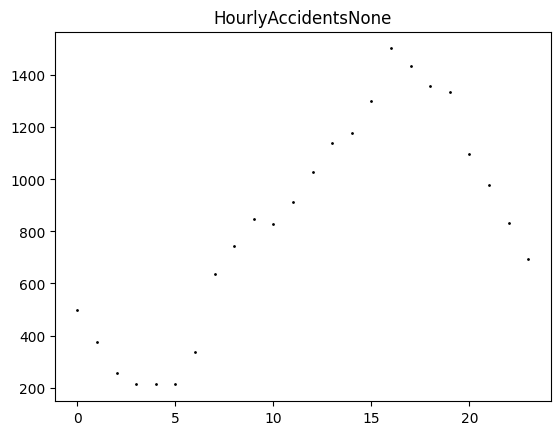

In [64]:
cosinor.plot_data(df_plot, names = ["HourlyAccidentsNone"])

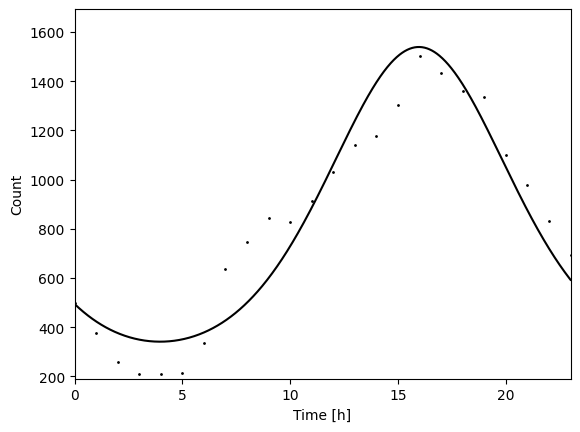

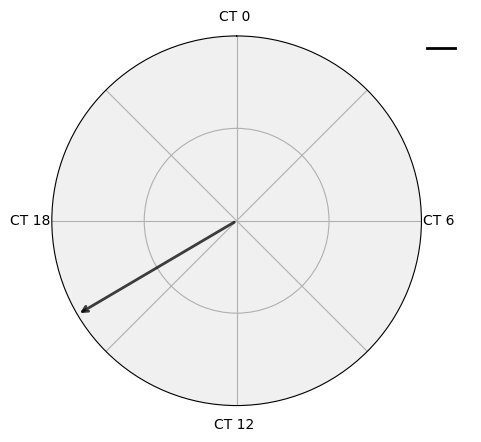

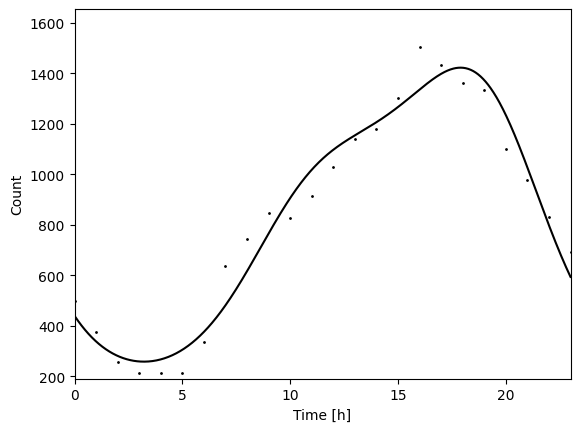

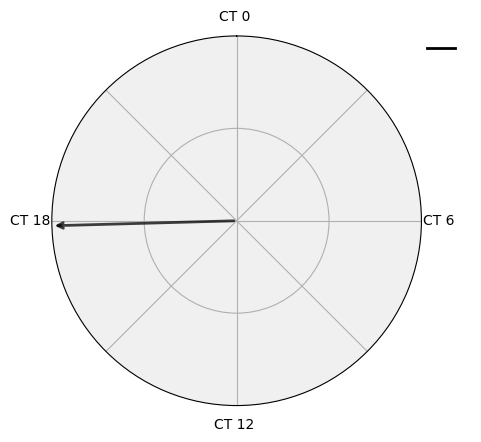

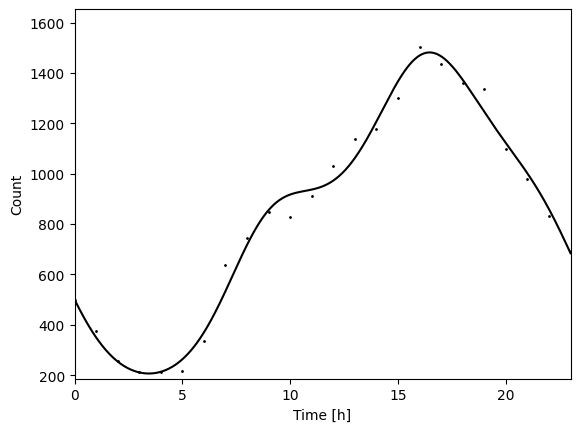

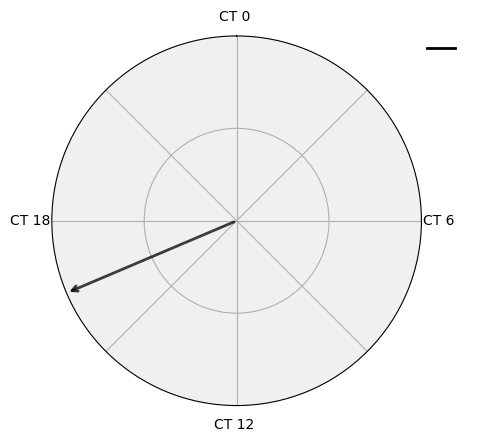

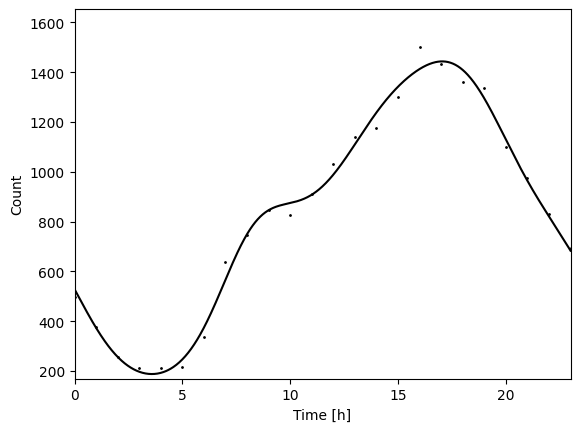

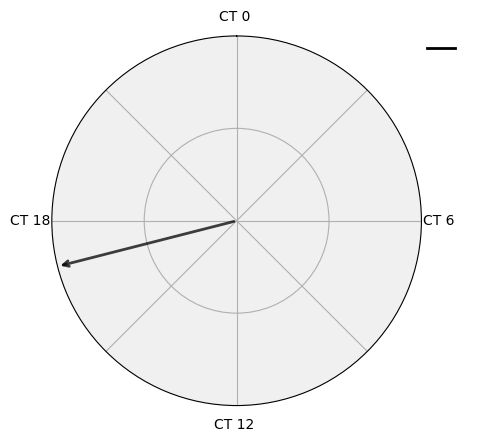

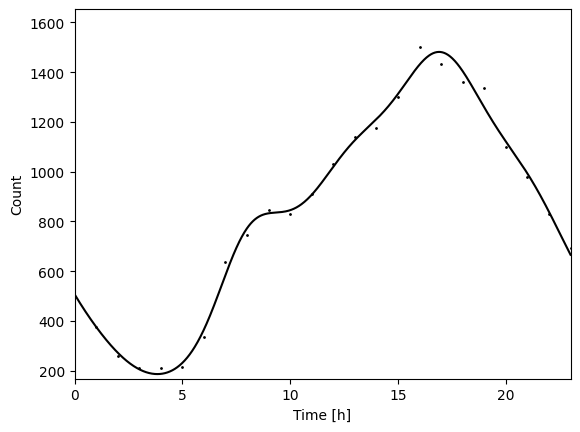

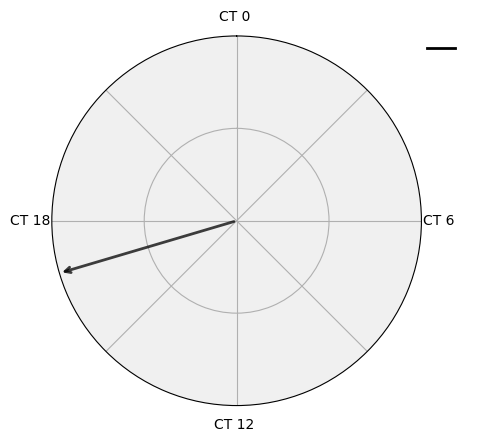

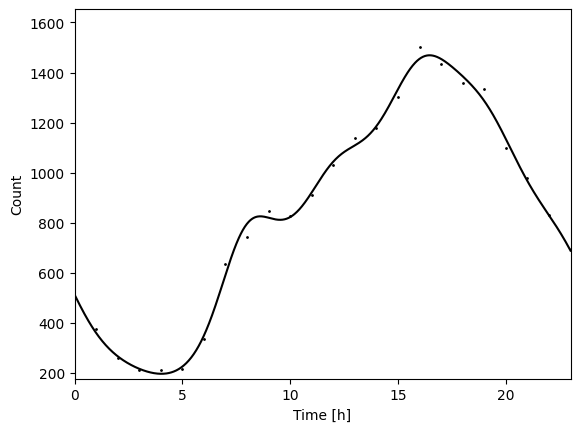

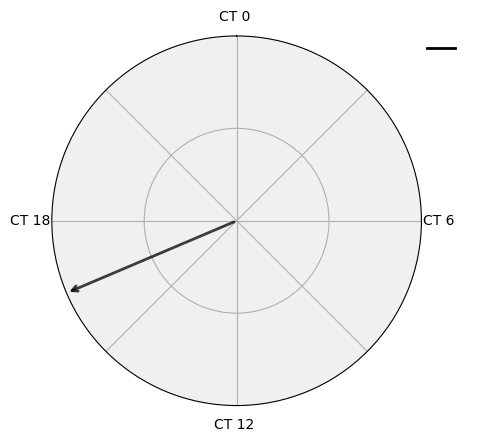

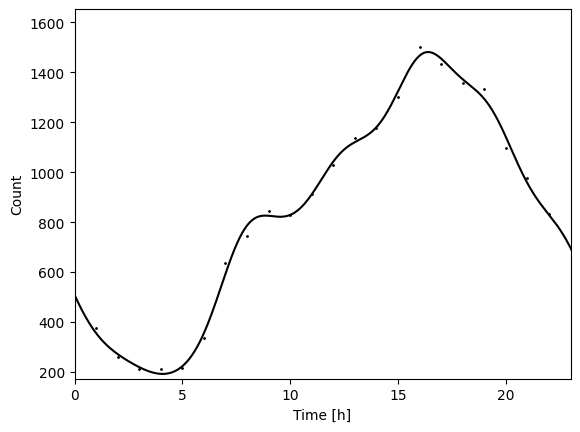

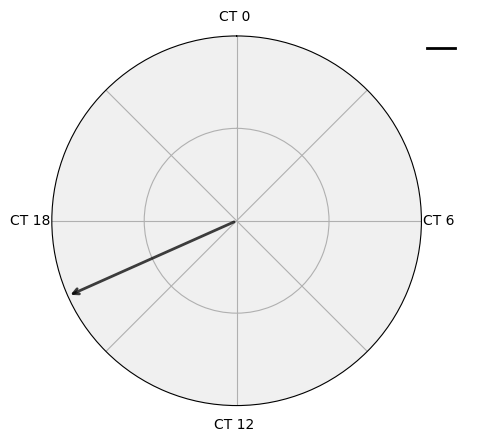

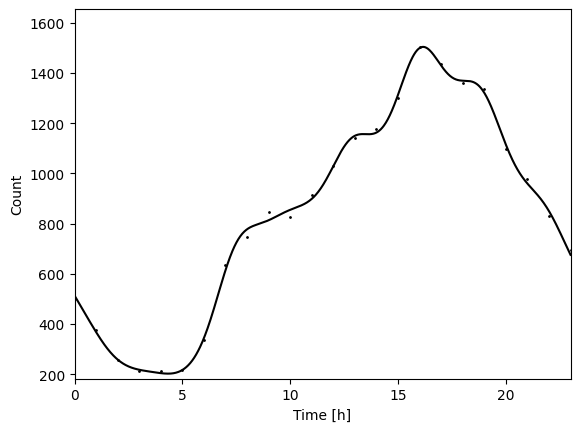

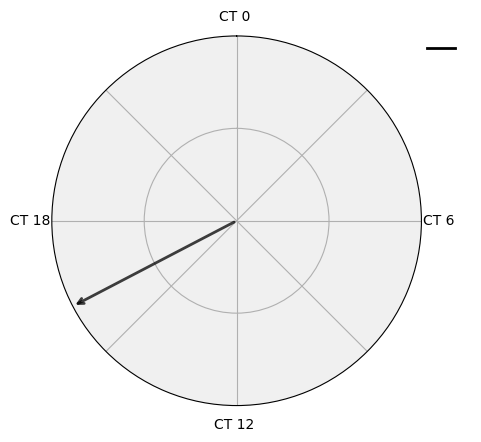

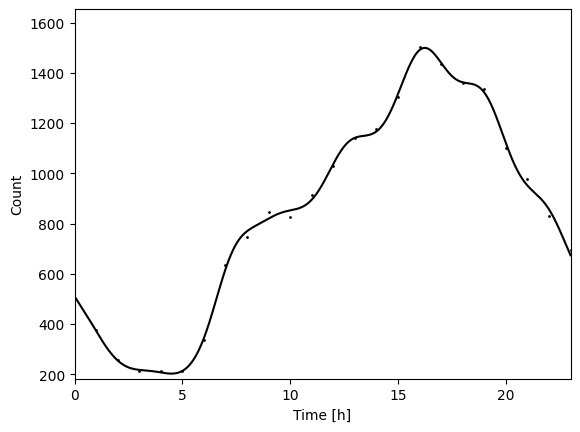

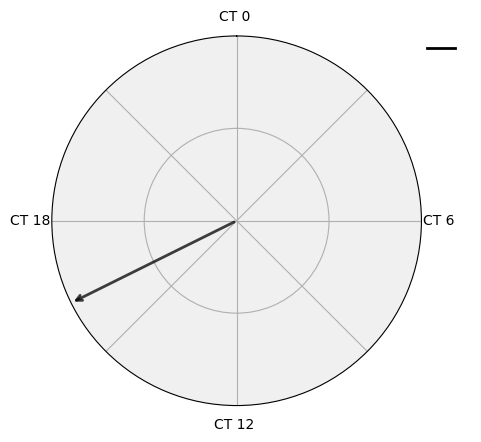

In [54]:
X = df_plot.x.to_numpy()
Y = df_plot.y.to_numpy()

df_results = pd.DataFrame(columns=[
    'test', 'period', 'n_components', 'p', 'q', 'RSS', 
    'log-likelihood', 'prsquared', 'amplitude', 'acrophase', 
    'mesor', 'peaks', 'heights', 'troughs', 'heights2'
], dtype=float)

all_models = []

numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9]
for n_component in numbers:
    results, statistics, rhythm_param, _, _, model = cosinor.fit_me(X, Y, n_components = n_component, period = 24, model_type = 'gen_poisson', plot_margins=False, return_model=True)
    #result_table.append(result)

    # print("Statistics:", statistics.keys())
    # print("Rhythm parameters:", rhythm_param.keys())
    # print("Results attributes:", dir(results))
    # print(results.__dict__.keys())
    # print(results.summary())
    # print("AIC in BIC", results.aic, results.bic)
    # help(results)


    df_results = df_add_row(df_results, {
        'test': 'HourlyAccidentsNone', 
        'period': 24,
        'n_components': n_component,
        'p': statistics['p'], 
        'RSS': statistics['RSS'],
        'log-likelihood': results.llf,        
        'prsquared': results.prsquared,  # Alternative to R²
        'AIC': results.aic,
        'BIC': results.bic,
        'amplitude': rhythm_param['amplitude'],
        'acrophase': rhythm_param['acrophase'],
        'mesor': rhythm_param['mesor'],
        'peaks': rhythm_param['peaks'],
        'heights': rhythm_param['heights'],
        'troughs': rhythm_param['troughs'],
        'heights2': rhythm_param['heights2']
    })

    # Likelihood-ratio test
    if n_component == 1:
        DOF_simpler = 0
        n_params_simpler = 0
        n_component_simpler = 0
        results_simpler, statistics_simpler, rhythm_param_simpler, model_simpler = results, statistics, rhythm_param, model
        
    n_params = len(results.params)
    DOF = len(df_plot)-n_params
    llf = results.llf

    p_accept_llf = 0
    
    if DOF < DOF_simpler:
        p_accept_llf = cosinor.compare_models_LR_test(llf_simpler, llf, n_params_simpler, n_params)

    llf_simpler = llf
    DOF_simpler = DOF

    if p_accept_llf < 0.05:
        n_component_simpler, results_simpler, statistics_simpler, rhythm_param_simpler, model_simpler = n_component, results, statistics, rhythm_param, model

    all_models.append(['HourlyAccidentsNone', n_component, results, statistics, rhythm_param, model, p_accept_llf])

df_results.q = multi.multipletests(df_results.p, method = 'fdr_bh')[1]

# Dataframe za najboljši model na podlagi likelihood-ratio testa
df_best_model = pd.DataFrame([{
        'test': 'HourlyAccidentsNone',
        'period': 24,
        'n_components': n_component_simpler,
        'p': statistics_simpler['p'], 
        'RSS': statistics_simpler['RSS'],
        'log-likelihood': results_simpler.llf,        
        'prsquared': results_simpler.prsquared,  # Alternative to R²
        'AIC': results_simpler.aic,
        'BIC': results_simpler.bic,
        'amplitude': rhythm_param_simpler['amplitude'],
        'acrophase': rhythm_param_simpler['acrophase'],
        'mesor': rhythm_param_simpler['mesor'],
        'peaks': rhythm_param_simpler['peaks'],
        'heights': rhythm_param_simpler['heights'],
        'troughs': rhythm_param_simpler['troughs'],
        'heights2': rhythm_param_simpler['heights2']
    }])

In [59]:
display(df_results)

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2,AIC,BIC
0,HourlyAccidentsNone,24.0,1.0,5.764624e-13,5.764624e-13,398443.215135,-152.264109,0.156179,598.985899,2.103192,940.387475,[15.966396639663968],[1539.3732317152665],[3.9699969996999704],[341.40159458613203],312.528218,317.240433
1,HourlyAccidentsNone,24.0,2.0,8.547827e-17,9.616306e-17,158249.864122,-139.716498,0.225716,581.643048,1.597974,840.019751,[17.8961896189619],[1421.6626986329832],[3.2163216321632166],[258.37678695383573],291.432995,298.501318
2,HourlyAccidentsNone,24.0,3.0,1.226554e-21,1.576998e-21,50869.652487,-124.919306,0.307719,637.298106,1.972489,844.103930,[16.465646564656467],[1481.401752798731],[3.446744674467447],[206.80585320490763],265.838611,275.263042
3,HourlyAccidentsNone,24.0,4.0,9.124159e-23,1.368624e-22,32645.595655,-119.089837,0.340025,627.651011,1.820421,815.760485,[17.04650465046505],[1443.4114958574532],[3.5859585958595863],[188.10947423923122],258.179674,269.960213
4,HourlyAccidentsNone,24.0,5.0,2.344635e-23,4.220344e-23,24486.795617,-114.712501,0.364283,647.337003,1.858124,834.014272,[16.902490249024904],[1481.3510636509714],[3.840384038403841],[186.67726963705914],253.425002,267.561648
5,HourlyAccidentsNone,24.0,6.0,2.962716e-24,8.888149e-24,15851.252949,-109.689118,0.392122,636.131183,1.972489,832.808258,[16.465646564656467],[1468.9392636320401],"[4.027602760276028, 9.52895289528953]","[196.6770748994723, 811.685428285244]",247.378236,263.870989
6,HourlyAccidentsNone,24.0,7.0,1.435503e-23,3.229881e-23,12553.591580,-108.702728,0.397589,644.591359,1.990084,836.793848,[16.3984398439844],[1481.3847345360298],"[4.08040804080408, 9.538553855385539]","[192.20259077140705, 821.6631514373946]",249.405457,268.254318
7,HourlyAccidentsNone,24.0,8.0,3.301679e-26,2.971511e-25,6016.963405,-99.448263,0.448875,650.698318,2.051665,853.106256,"[13.37893789378938, 16.163216321632163]","[1156.482705847677, 1503.8043523090257]",[4.334833483348335],[202.40796581375756],234.896527,256.101496
8,HourlyAccidentsNone,24.0,9.0,9.535432e-26,4.290944e-25,5714.977826,-98.044864,0.456653,648.142515,2.031557,850.926040,[16.24002400240024],[1499.0685550052053],[4.488448844884489],[202.7836693563087],236.089727,259.650804


### Katero je najboljše število komponent

In [60]:
# df_best_model = cosinor.get_best_models(df_plot, df_results, n_components = [1,2,3,4,5,6,7,8,9,10])
df_best_model
# print(df_best_model)

,test,period,n_components,p,RSS,log-likelihood,prsquared,AIC,BIC,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsNone,24,3,1.226554e-21,50869.652487,-124.919306,0.307719,265.838611,275.263042,637.298106,1.972489,844.10393,[16.465646564656467],[1481.401752798731],[3.446744674467447],[206.80585320490763]


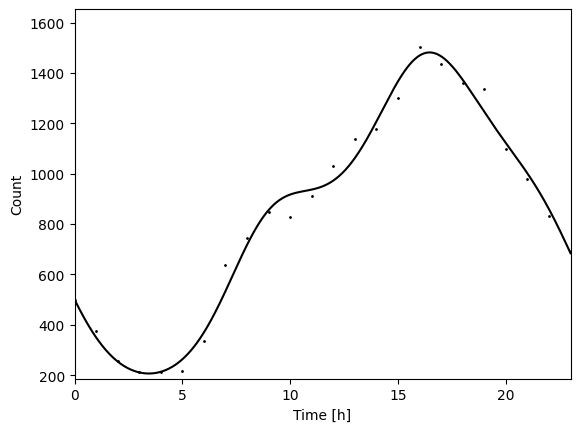

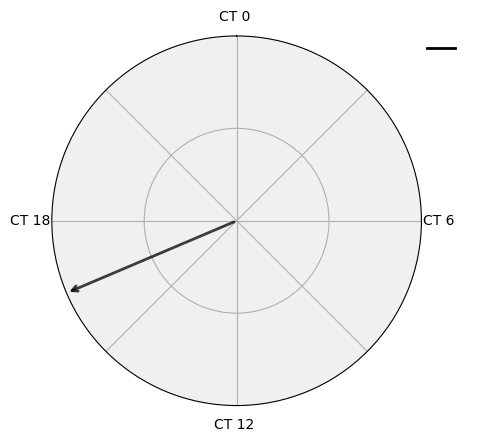

(<statsmodels.discrete.discrete_model.GeneralizedPoissonResultsWrapper at 0x1bf39b48ec0>,
 {'p': 1.2265538391256452e-21, 'RSS': 50869.652487444415, 'count': 19954},
 {'period': 24,
  'amplitude': 637.2981064187152,
  'acrophase': 1.972489116835355,
  'mesor': 844.1039304859315,
  'peaks': array([16.46564656]),
  'heights': array([1481.4017528]),
  'troughs': array([3.44674467]),
  'heights2': array([206.8058532]),
  'max_loc': 3430,
  'period2': 24},
 array([0.00000000e+00, 4.80048005e-03, 9.60096010e-03, ...,
        4.79903990e+01, 4.79951995e+01, 4.80000000e+01]),
 array([500.72047787, 499.89024208, 499.06082211, ..., 502.38338014,
        501.55152528, 500.72047787]))

In [ ]:
# cosinor.fit_me(X, Y, n_components = 3, period = 24, model_type = 'gen_poisson', save_to = "../PisanjeDiplome/angleskeSlike/kosinor-brez-mene", plot=True, plot_margins=False)
cosinor.fit_me(X, Y, n_components = 3, period = 24, model_type = 'gen_poisson', plot=True, plot_margins=False)

## RhythmCount

In [43]:
# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo RhythmCount
df_plot_RC = pd.DataFrame({
    "test": "HourlyAccidentsNone",  # konstantna oznaka vseh vrstic
    "X": accidents_per_hour.index,  # Ura (od 0 do 23)
    "Y": accidents_per_hour.values  # Število nesreč za tisto uro
})

In [44]:
count_models = ['gen_poisson', 'nb']
n_components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

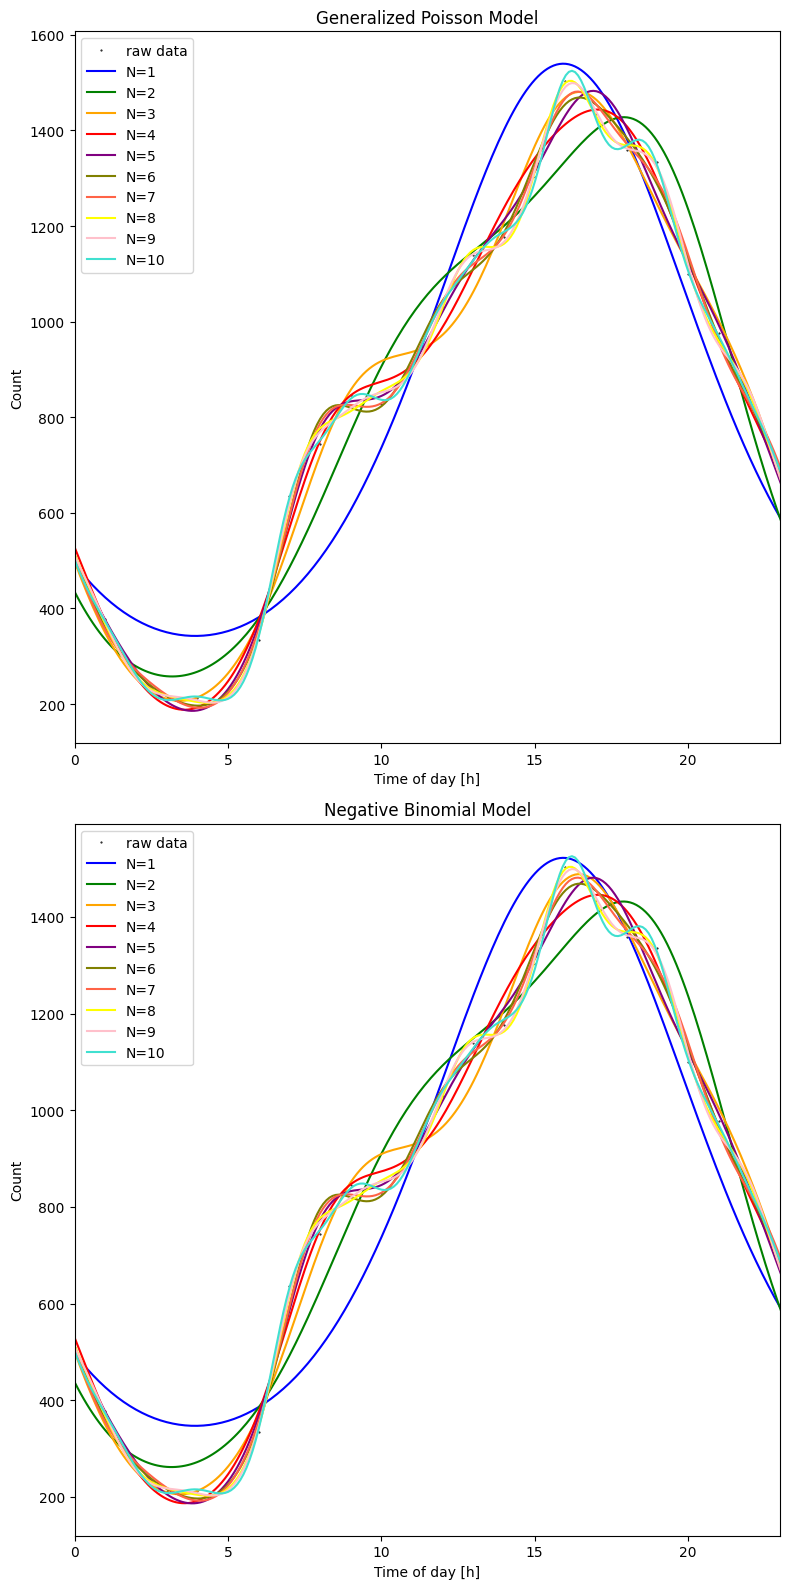

In [45]:
df_results_RC = dproc.fit_to_models(df_plot_RC, count_models, n_components, 24)

In [46]:
display(df_results_RC)

,count_model,n_components,amplitude,mesor,peaks,heights,llr_pvalue,RSS,AIC,BIC,log_likelihood,logs,mean(est),Y(est),X_test,Y_test
0,gen_poisson,1,598.53,941.10,[15.92],[1539.63],5.811798e-13,400770.862227,312.544517,317.256733,-152.272259,"[-5.698841943859918, -5.557642190496381, -5.98...",832.430358,"[493.2426232104117, 423.03618321945277, 376.43...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[493.2426232104117, 485.0512178566582, 477.128..."
1,gen_poisson,2,584.98,842.79,[17.92],[1427.77],8.730829e-17,157437.425190,291.476402,298.544725,-139.738201,"[-5.67084364803884, -5.351590659338797, -4.872...",830.986166,"[435.46706378163617, 335.1581461859006, 279.15...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[435.46706378163617, 423.1392952699856, 411.34..."
2,gen_poisson,3,636.83,843.64,[16.42],[1480.48],2.633342e-21,50664.195640,267.423144,276.847575,-125.711572,"[-4.365986658896304, -4.794324422628165, -4.06...",831.416667,"[499.1272697841836, 348.9960298638128, 253.732...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[499.1272697841836, 481.9983638617814, 465.264..."
3,gen_poisson,4,627.76,815.92,[17.02],[1443.68],2.340703e-22,32556.066763,260.159878,271.940416,-120.079939,"[-4.867972269030474, -3.9785717154364875, -3.7...",831.416667,"[528.4703010023445, 373.1793786694703, 256.610...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[528.4703010023445, 512.3201223339106, 496.181..."
4,gen_poisson,5,648.48,834.34,[16.92],[1482.82],5.641835e-23,24525.078409,255.293895,269.430541,-115.646947,"[-4.035836762940448, -3.7909087163407094, -4.0...",831.827028,"[507.3448545262846, 376.2938353897498, 272.484...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[507.3448545262846, 493.0061794917279, 478.950..."
5,gen_poisson,6,636.03,832.74,[16.42],[1468.77],2.974805e-24,15850.987595,247.386990,263.879743,-109.693495,"[-4.202288855671782, -4.259016753182038, -3.77...",831.416667,"[513.2586189624035, 360.08474978995486, 266.82...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[513.2586189624035, 495.7516026468759, 478.578..."
6,gen_poisson,7,644.61,836.78,[16.42],[1481.39],1.525531e-23,12543.571695,249.538041,268.386902,-108.769021,"[-4.057732405494505, -4.56409787697595, -4.018...",831.416667,"[508.7206530684082, 355.53478457426456, 271.55...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[508.7206530684082, 490.2032132675508, 472.243..."
7,gen_poisson,8,650.55,853.09,"[13.41, 16.12]","[1156.57, 1503.64]",8.507395e-25,6009.787822,242.015400,263.220369,-103.007700,"[-4.207064889414255, -3.905837881674927, -3.58...",831.416667,"[513.3864730853336, 368.0724326083408, 258.702...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[513.3864730853336, 498.6194728489607, 483.913..."
8,gen_poisson,9,648.07,851.08,[16.22],[1499.15],5.119752e-24,5716.643074,244.926137,268.487214,-102.463068,"[-4.109188083122831, -3.7998177495342134, -3.6...",831.416667,"[510.5190587962299, 372.9982018913733, 255.258...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[510.5190587962299, 497.08566847901926, 483.76..."
9,gen_poisson,10,658.47,866.32,"[16.22, 18.42]","[1524.79, 1380.67]",2.195676e-24,1435.027757,242.128752,268.045936,-99.064376,"[-3.938843128899009, -3.798422915703668, -3.61...",831.416667,"[502.42095584238655, 373.10625105531665, 261.5...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[502.42095584238655, 486.17457453973685, 470.8..."


## Kateri model je najboljši?

#### Najprej pogledamo, kateri model je najboljši, nato kolikšno število komponent je najboljše.

In [47]:
best_count_model = dproc.get_best_count_model(df_results_RC, 'Vuong')
print("Best model: {}".format(best_count_model.count_model))
best_model = dproc.get_best_n_components(df_results_RC, 'Vuong', count_model=best_count_model['count_model'])
print("Number of components: {}".format(best_model.n_components))

Best model: gen_poisson
Number of components: 8


#### Najprej pogledamo, kolikšno število komponent je najboljše, nato, kateri model je najboljši. 

In [48]:
best_n_components = dproc.get_best_n_components(df_results_RC, 'Vuong')
print("Number of components: {}".format(best_n_components.n_components))
best_model = dproc.get_best_count_model(df_results_RC, 'Vuong', n_components=best_n_components['n_components'])
print("Best model: {}".format(best_model.count_model))

Number of components: 8
Best model: gen_poisson


### Prikaz najboljšega modela skupaj z intervali zaupanja

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian

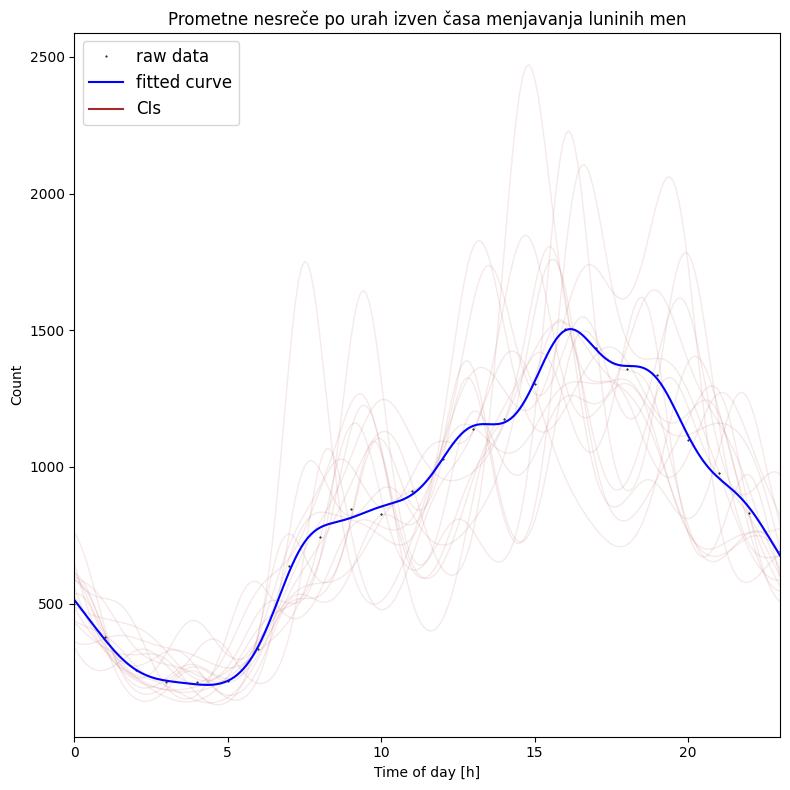

Intervali zaupanja:


,0,1
0,6.448906,6.628913
1,-0.803496,-0.514381
2,-0.526240,-0.350652
3,-0.377362,-0.164202
4,-0.065426,0.080296
5,-0.157335,0.099019
6,-0.002703,0.319315
7,-0.055472,0.142251
8,-0.182986,0.170693
9,-0.138311,0.109746


In [49]:
# print(type(best_model))
# print(type(best_n_components))

# print(best_n_components)

count_model = best_model.count_model
n_components = int(best_n_components.n_components)

CIs = plot.plot_model(df_plot_RC, count_model, n_components, title='Prometne nesreče po urah izven časa menjavanja luninih men', plot_CIs=True)
print('Intervali zaupanja:')
display(CIs)

### Parametri izbranega modela

In [50]:
CIs_params = dproc.calculate_confidence_intervals_parameters(df_plot_RC, n_components, count_model, best_model['peaks'])
best_model = pd.concat([best_model, pd.Series(CIs_params)], axis=0)
best_model=best_model[['count_model','n_components','amplitude', 'mesor', 'peaks', 'heights','amplitude_CIs','mesor_CIs','peaks_CIs','heights_CIs']]
print('Parametri modela in njihovi intervali zaupanja:')
display(best_model.to_frame())

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  war

Parametri modela in njihovi intervali zaupanja:


c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,0
count_model,gen_poisson
n_components,8
amplitude,650.55
mesor,853.09
peaks,"[13.41, 16.12]"
heights,"[1156.57, 1503.64]"
amplitude_CIs,"[252.22, 1293.88]"
mesor_CIs,"[448.26, 1496.87]"
peaks_CIs,"[[12.68, 14.74], [14.8, 17.61]]"
heights_CIs,"[[104.87, 2937.35], [632.69, 2764.03]]"
